In [1]:
import os
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION' ] = 'python'

In [2]:
from lass.log_handling import LogLoaderArgs, LogLoader


args = LogLoaderArgs(
    logdir="../artifacts/logs",
    tasks="paper-full",
    model_families=["BIG-G T=0"],
    model_sizes=["128b"],
    # model_sizes=["2m"],
    shots=[3],
    # query_types=["multiple_choice"],
)
loader = LogLoader(args)

In [3]:
tasks = list(loader.load_per_task())

In [4]:
import bigbench.api.results as bb

In [5]:
def query_class_to_type(query):
    if query.__class__ == bb.MultipleChoiceQuery:
        return "multiple_choice"
    elif query.__class__ == bb.GenerativeQuery:
        return "generative"
    elif query.__class__ == bb.ScoringQuery:
        return "scoring"
    else:
        raise ValueError(f"Unknown query class: {query.__class__}")

In [6]:
from collections import defaultdict

task_types = defaultdict(list)
for task in tasks:
    run = task[list(task.keys())[0]]
    types = [query_class_to_type(query) for query in run.queries]
    for type_ in set(types):
        task_types[type_].append(run.task.task_name)

    if len(set(types)) > 1:
        task_types["mixed"].append(run.task.task_name)

{key: len(value) for key, value in task_types.items()}

{'multiple_choice': 118, 'generative': 54, 'mixed': 54, 'scoring': 53}

In [7]:
task_types["generative"]

['arithmetic',
 'ascii_word_recognition',
 'auto_categorization',
 'auto_debugging',
 'bridging_anaphora_resolution_barqa',
 'checkmate_in_one',
 'chess_state_tracking',
 'chinese_remainder_theorem',
 'codenames',
 'color',
 'conlang_translation',
 'cryptonite',
 'disfl_qa',
 'emoji_movie',
 'few_shot_nlg',
 'gem',
 'gender_inclusive_sentences_german',
 'geometric_shapes',
 'hindi_question_answering',
 'international_phonetic_alphabet_transliterate',
 'kanji_ascii',
 'language_games',
 'linguistic_mappings',
 'linguistics_puzzles',
 'list_functions',
 'matrixshapes',
 'minute_mysteries_qa',
 'modified_arithmetic',
 'mult_data_wrangling',
 'natural_instructions',
 'object_counting',
 'operators',
 'paragraph_segmentation',
 'parsinlu_reading_comprehension',
 'penguins_in_a_table',
 'physics_questions',
 'polish_sequence_labeling',
 'qa_wikidata',
 'repeat_copy_logic',
 'rephrase',
 'scientific_press_release',
 'semantic_parsing_in_context_sparc',
 'semantic_parsing_spider',
 'similariti

In [8]:
task_types["mixed"]

['arithmetic',
 'ascii_word_recognition',
 'auto_categorization',
 'auto_debugging',
 'bridging_anaphora_resolution_barqa',
 'checkmate_in_one',
 'chess_state_tracking',
 'chinese_remainder_theorem',
 'codenames',
 'color',
 'conlang_translation',
 'cryptonite',
 'disfl_qa',
 'emoji_movie',
 'few_shot_nlg',
 'gem',
 'gender_inclusive_sentences_german',
 'geometric_shapes',
 'hindi_question_answering',
 'international_phonetic_alphabet_transliterate',
 'kanji_ascii',
 'language_games',
 'linguistic_mappings',
 'linguistics_puzzles',
 'list_functions',
 'matrixshapes',
 'minute_mysteries_qa',
 'modified_arithmetic',
 'mult_data_wrangling',
 'natural_instructions',
 'object_counting',
 'operators',
 'paragraph_segmentation',
 'parsinlu_reading_comprehension',
 'penguins_in_a_table',
 'physics_questions',
 'polish_sequence_labeling',
 'qa_wikidata',
 'repeat_copy_logic',
 'rephrase',
 'scientific_press_release',
 'semantic_parsing_in_context_sparc',
 'semantic_parsing_spider',
 'similariti

In [9]:
generative_non_mpc = set(task_types["generative"]) - set(task_types["multiple_choice"])
generative_only = set(task_types["generative"]) - set(task_types["mixed"])
print(len(generative_only))
generative_only

0


set()

In [10]:
# ascii_word_recognition: single word output, big discrete set
# auto_categorization: single word output, big discrete set
# auto_debugging: single word output, big discrete set
# bridging_anaphora: multiple word output, small set (from context)
# chess_state_tracking: multiple word output, small discrete set (64 options) (but arbitrary length)
# chinese_remainder_theorem: single word output, big discrete set
# codenames: single word output, big discrete set
# All QA or math?

In [11]:
print(len(generative_non_mpc))
generative_non_mpc

43


{'ascii_word_recognition',
 'auto_categorization',
 'auto_debugging',
 'bridging_anaphora_resolution_barqa',
 'chess_state_tracking',
 'chinese_remainder_theorem',
 'codenames',
 'conlang_translation',
 'cryptonite',
 'disfl_qa',
 'few_shot_nlg',
 'gem',
 'gender_inclusive_sentences_german',
 'hindi_question_answering',
 'international_phonetic_alphabet_transliterate',
 'language_games',
 'linguistic_mappings',
 'linguistics_puzzles',
 'list_functions',
 'matrixshapes',
 'modified_arithmetic',
 'mult_data_wrangling',
 'natural_instructions',
 'object_counting',
 'operators',
 'paragraph_segmentation',
 'parsinlu_reading_comprehension',
 'physics_questions',
 'polish_sequence_labeling',
 'qa_wikidata',
 'repeat_copy_logic',
 'rephrase',
 'scientific_press_release',
 'semantic_parsing_in_context_sparc',
 'semantic_parsing_spider',
 'simp_turing_concept',
 'simple_text_editing',
 'sufficient_information',
 'tense',
 'topical_chat',
 'unnatural_in_context_learning',
 'word_sorting',
 'word

In [12]:
exact_string_match_tasks = []
exact_string_match_tasks_over_10 = []
for task in tasks:
    run = task[list(task.keys())[0]]
    if run.task.task_name not in generative_non_mpc:
        continue
    types = [query_class_to_type(query) for query in run.queries]
    pref_metrics = [score.preferred_score for score in run.scores]
    if len(list(filter(lambda m: m == "exact_str_match", pref_metrics))) == 0:
        continue
    avg_score = sum([score.score_dict["exact_str_match"] for score in run.scores if score.preferred_score == "exact_str_match"]) / len(run.scores)
    print(f"#{run.task.task_name}: {avg_score} ({len(run.scores)})")
    exact_string_match_tasks.append(run.task.task_name)
    if avg_score > 10:
        exact_string_match_tasks_over_10.append(run.task.task_name)
print(len(exact_string_match_tasks))
len(exact_string_match_tasks_over_10)

#ascii_word_recognition: 0.68359375 (4)
#auto_debugging: 0.0 (4)
#bridging_anaphora_resolution_barqa: 4.359567901234568 (4)
#chess_state_tracking: 28.592436974789916 (28)
#chinese_remainder_theorem: 0.0 (4)
#cryptonite: 2.392578125 (4)
#disfl_qa: 4.638671875 (4)
#gender_inclusive_sentences_german: 0.125 (4)
#language_games: 0.0 (28)
#linguistic_mappings: 51.0506221719457 (52)
#linguistics_puzzles: 0.0 (4)
#list_functions: 14.37659033078885 (1048)
#matrixshapes: 11.5966796875 (4)
#modified_arithmetic: 14.243697478991596 (28)
#mult_data_wrangling: 57.21153846153846 (988)
#object_counting: 15.225000000000001 (4)
#operators: 26.42857142857143 (4)
#paragraph_segmentation: 0.1953125 (4)
#parsinlu_reading_comprehension: 0.3861003861003861 (4)
#physics_questions: 2.0 (4)
#repeat_copy_logic: 7.8125 (4)
#simp_turing_concept: 30.755131964809387 (16)
#simple_text_editing: 0.0 (4)
#sufficient_information: 0.0 (4)
#tense: 1.486013986013986 (4)
#unnatural_in_context_learning: 35.611979166666664 (36)


12


#abstract_narrative_understanding: 34.164222873900286 (16)

#anachronisms: 51.52173913043478 (4)

#analogical_similarity: 18.188854489164086 (4)

#analytic_entailment: 46.07142857142857 (4)

#authorship_verification: 50.3409090909091 (12)

#bbq_lite_json: 56.37400793650795 (76)

#causal_judgment: 51.8421052631579 (4)

#cause_and_effect: 69.28104575163398 (16)

#cifar10_classification: 10.107421875 (12)

#code_line_description: 30.0 (4)

#color: 9.033203125 (20)

#common_morpheme: 39.0 (4)

#conceptual_combinations: 37.38756613756614 (28)

#crash_blossom: 42.10526315789473 (4)

#crass_ai: 22.727272727272727 (4)

#cryobiology_spanish: 59.76027397260273 (4)

#cs_algorithms: 33.5302734375 (12)

#dark_humor_detection: 54.375 (4)

#date_understanding: 55.96205962059621 (4)

#disambiguation_qa: 35.56201550387597 (4)

#discourse_marker_prediction: 11.843640606767796 (4)

#dyck_languages: 18.475 (4)

#elementary_math_qa: 21.1764705882353 (24)

#emoji_movie: 36.0 (4)

#emojis_emotion_prediction

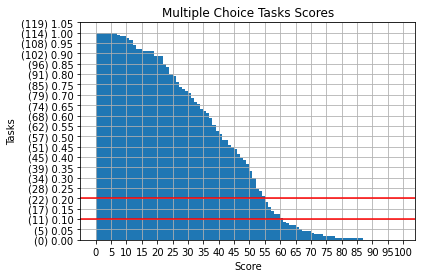

In [43]:
mpc = set(task_types["multiple_choice"])
mpc_tasks = []
mpc_tasks_scores = {}
for task in tasks:
    run = task[list(task.keys())[0]]
    if run.task.task_name not in mpc:
        continue
    types = [query_class_to_type(query) for query in run.queries]
    pref_metrics = [score.preferred_score for score in run.scores]
    # print(pref_metrics)
    if len(list(filter(lambda m: m == "multiple_choice_grade", pref_metrics))) == 0:
        continue
    print()
    avg_score = sum([score.score_dict["multiple_choice_grade"] for score in run.scores if score.preferred_score == "multiple_choice_grade"]) / len(run.scores)
    print(f"#{run.task.task_name}: {avg_score} ({len(run.scores)})")
    mpc_tasks.append(run.task.task_name)
    mpc_tasks_scores[run.task.task_name] = avg_score
print(len(mpc_tasks))

# Plot the scores
# x-axis is the score, and y-axis is the number of tasks with that score
# Plot should be cumulative, i.e. "at leas that score"
import matplotlib.pyplot as plt
import numpy as np

scores = list(mpc_tasks_scores.values())
scores.sort()
plt.hist(scores, bins=np.arange(0, 100, 1), cumulative=-1, density=True)
# Make the y-axis absolute numbers
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"({int(x * len(mpc_tasks))}) {x:.2f}")
)
# Do a lot more ticks on the x-axis and y-axis
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(0.05))

# Draw a line on the y-axis at 20% of the tasks
plt.axhline(0.2, color="red")
plt.axhline(0.1, color="red")

# Plot grid
plt.grid(True)

plt.xlabel("Score")
plt.ylabel("Tasks")
plt.title("Multiple Choice Tasks Scores")
plt.show()